# Gumbel integral 
In this notebook we present an efficient way of evaluating the gumbel integral using results from Fog https://www.tandfonline.com/doi/abs/10.1080/03610910701790236


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import random
import sys
import os

sys.path.append('../cmc/')
from methods import *

In [58]:
# Toy example
seed = 0
N = 1000000     # population size
n = 1000       # sample size
random.seed(seed)

w = np.linspace(0.1,1000,N)    # weights 
w = w/sum(w)
#s = random.sample(list(np.arange(N)),n)   # sample indexed  
s = np.arange(N)[:n]
sc = list(set(np.arange(N))-set(s))       # remaining indexes
d = sum(w[sc])    # weight sum of S complement

print('Population size is {}, sample size is {}, sample weight sum is {:.12f}.'.format(N,n,1-d))

Population size is 1000000, sample size is 1000, sample weight sum is 0.000001198781.


In [59]:
mw = mwnchypg(verbose=True)
# _,_ = mw.direct_integral(w, s)
logscale=1

In [60]:
# _,_ = mw.transformed_integral(w, s)

In [61]:
_ = mw.laplace_approx(w, s, logscale=logscale)

Laplace's method
-------------------------
Log-scaled result: -1070.120764597672


scaling parameter: 1443.695906222766


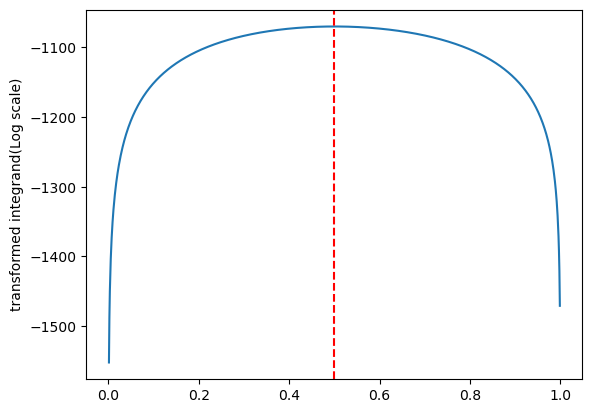

The reciprocal of d is 1.0000011987826578, note if the value is too large, Laplace method is generally not recommended.


In [62]:
mw.check_shape(w, s, logscale=logscale)